In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle

import os
import glob
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label

from collections import deque

In [2]:
#Find cars on test images
location="./test_images/*.jpg"
files=glob.glob(location)
images=[]
titles=[]

In [3]:
#List of images of car[] & notcar[]

image_types=os.listdir('vehicles/')
cars=[]

for imtype in image_types:
    cars.extend(glob.glob('vehicles/'+imtype+'/*.png'))
    
print("cars: ",len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+"\n")

image_types=os.listdir('non-vehicles/')
notcars=[]

for imtype in image_types:
    notcars.extend(glob.glob('non-vehicles/'+imtype+'/*.png'))
    
print("notcars: ",len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+"\n")

cars:  8792
notcars:  8968


In [4]:
#Define the 
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    return feature_image

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


#### Find window sizes

In [6]:
img=mpimg.imread(files[2])
#plt.imshow(img)
img2=np.copy(img)
win_list=[]
y_start_stop_2=[[400,500],[500,600],[600,700]]
green=(0,255,0)
blue=(0,0,255)
red=(255,0,0)
colors=[green,red,blue]
print(colors)

for y_start_stop_2_,color in zip(y_start_stop_2,colors):
    boxes=slide_window(img,y_start_stop=y_start_stop_2_)
    img2=draw_boxes(img2,boxes,color=color)
    plt.imshow(img2)

[(0, 255, 0), (255, 0, 0), (0, 0, 255)]


In [7]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis==True:
                hog_features,hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features),hog_images
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [23]:
def visualize(fig,rows,cols,imgs,titles):
    plt.clf()
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims=len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Parameters

In [9]:
#Define Paramaters
y_start_stop =[400,700]
ystart=y_start_stop[0]
ystop=y_start_stop[1]
xy_window = (64,64)
overlap = 0.5
color_space='YCrCb'
#Must be the same with training spatial_size
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel="ALL"
spatial_feat=True
hist_feat=True
hog_feat=True
n_frames=5
scales = [1.8,2.2]
threshold=3

C:\Users\DELL\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


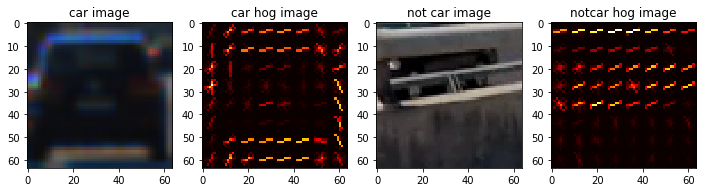

In [10]:
%matplotlib inline

hog_channel_example=0

car_ind=np.random.randint(0,len(cars))
notcar_ind=np.random.randint(0,len(notcars))

car_img= mpimg.imread(cars[car_ind])
notcar_img=mpimg.imread(notcars[notcar_ind])

car_features,car_hog_image=single_img_features(car_img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel_example,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,vis=True)

notcar_features,notcar_hog_image=single_img_features(notcar_img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel_example,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,vis=True)

images=[car_img,car_hog_image,notcar_img,notcar_hog_image]
titles=['car image','car hog image','not car image','notcar hog image']
fig=plt.figure(figsize=[12,3])
visualize(fig,1,4,images,titles)


#### HOG Features of Vehicles and Not Vehicles

In [11]:
run=False
if run:
    t=time.time()
    #RGB Acc: 0.94, HLS Acc: 0.98, HSV Acc: 0.99, YCrCb Acc: 0.9935
    #Chosen YCrCb with spatial_size=(32, 32),hist_bins=32,orient=9,pix_per_cell=8,cell_per_block=2
    #hog_channel="ALL",spatial_feat=True,hist_feat=True,hog_feat=True
    #n_samples=500
    #random_idxs=np.random.randint(0,len(cars),n_samples)
    test_cars=cars#np.array(cars)[random_idxs]
    test_notcars=notcars#np.array(notcars)[random_idxs]

    car_features=extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features=extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    else: 
        print('Your function only returns empty feature vectors...')

    svc=LinearSVC()
    t=time.time()
    svc.fit(X_train,y_train)

    print('Train Time of SVC: ', round(time.time()-t, 2))
    print('Test Accuracy of SVC: ', round(svc.score(X_test,y_test),4))

    features_pickle = {}
    features_pickle["X_scaler"] = X_scaler
    features_pickle["scaled_X"] = scaled_X
    features_pickle["svc"] = svc
    pickle.dump( features_pickle, open( "./features.p", "wb" ) )

"""
Results:
#1
Train Time of SVC:  73.98
Test Accuracy of SVC:  0.993
#2
Train Time of SVC:  32.81
Test Accuracy of SVC:  0.9918
"""

'\nResults:\n#1\nTrain Time of SVC:  73.98\nTest Accuracy of SVC:  0.993\n#2\nTrain Time of SVC:  32.81\nTest Accuracy of SVC:  0.9918\n'

#### Load From Pickle File

In [27]:
features_pickle = pickle.load( open( "features.p", "rb" ) )
X_scaler = features_pickle["X_scaler"]
scaled_X = features_pickle["scaled_X"]
svc = features_pickle["svc"]

In [13]:
for test_file in files:
    image=mpimg.imread(test_file)
    t1=time.time()
    draw_img=np.copy(image)
    image=image.astype(np.float32)/255
    print(np.min(image),np.max(image))
    
    
    windows=slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window = xy_window, xy_overlap = (overlap,overlap))
    
    hot_windows= search_windows(image, windows, svc, X_scaler, 
                    color_space=color_space, spatial_size=spatial_size,
                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block,hog_channel=hog_channel, 
                    spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)    
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, "seconds to process one image:" ,len(windows), ' windows')
if False:
    fig = plt.figure(figsize=(12,18))
    visualize(fig, 6 ,2, images, titles)


0.0 1.0


C:\Users\DELL\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.6102840900421143 seconds to process one image: 312  windows
0.0 1.0
1.5180385112762451 seconds to process one image: 312  windows
0.0 1.0
1.4929702281951904 seconds to process one image: 312  windows
0.0 1.0
1.5170352458953857 seconds to process one image: 312  windows
0.0 1.0
1.5260581970214844 seconds to process one image: 312  windows
0.0 1.0
1.5721814632415771 seconds to process one image: 312  windows
0.0 1.0
1.5621559619903564 seconds to process one image: 312  windows
0.0 1.0
1.517059564590454 seconds to process one image: 312  windows
0.0 1.0
1.5310957431793213 seconds to process one image: 312  windows
0.0 1.0
1.5320994853973389 seconds to process one image: 312  windows
0.0 1.0
1.472917079925537 seconds to process one image: 312  windows


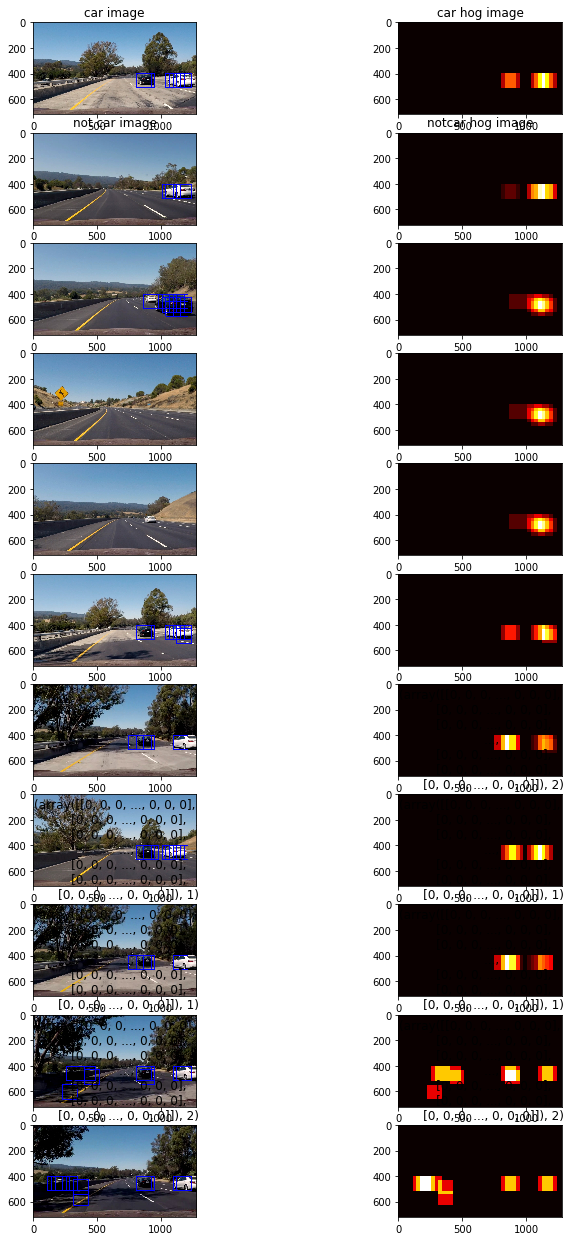

In [26]:
# Define a single function that can extract features using hog sub-sampling and make predictions
out_images=[]
out_maps=[]
out_titles=[]
out_boxes=[]
heatmaps = deque(maxlen = n_frames) # You can choose how many frames to use.

def find_cars(img, scales):
#def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    count=0
    img_boxes=[]
    t=time.time()
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    #Heat Map
    heatmap= np.zeros_like(img[:,:,0])
        
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    
    for scale in scales:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                count+=1
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                    heatmaps.append(heatmap)
                    #print("heatmaps len 1: ",len(heatmaps))
                    
        #print("scale: ",scale, "heatmaps len: ",len(heatmaps), "max heatmaps: ",np.max(heatmaps))
        if len(heatmaps) >= n_frames:
            heatmap = sum(heatmaps)            
       
        #print(time.time()-t,'seconds to run, total windows=', count)
     
    return draw_img, heatmap

#Run test on Test Images to Decide which parameters (check cell #9 for parameters) Gets The Best Results

if True:
    for file in files:    
        img = mpimg.imread(file)
        draw_img,heatmap = find_cars(img, scales)
        
        out_images.append(draw_img)
        out_images.append(heatmap)
        out_maps.append(heatmap)
     
        titles.append('')

    fig = plt.figure(figsize=(12,24))
    visualize(fig, 12 ,2, out_images, titles)

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

bbox_list=[]

def draw_labeled_bboxes(img, labels):
    
    ratio=0.8
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])        
        # Define a bounding box based on min/max x and y
        
        '''
        !Commented out after using sum of heatmaps for n_frames. Used to find cars found in same box for last 3 frames.
        Left on purpose to show how I implemented a way to find if it is a false-positive or a positive.
        
        if(len(bbox_list)>0):
            #print("bbox_list -1 :", np.array(bbox_list[-1])[0][0])
            min_nonzerox=np.int((ratio*np.min(nonzerox)+(1-ratio)*np.array(bbox_list[-1])[0][0]))
            min_nonzeroy=np.int((ratio*np.min(nonzeroy)+(1-ratio)*np.array(bbox_list[-1])[0][1]))
            max_nonzerox=np.int((ratio*np.max(nonzerox)+(1-ratio)*np.array(bbox_list[-1])[1][0]))
            max_nonzeroy=np.int((ratio*np.max(nonzeroy)+(1-ratio)*np.array(bbox_list[-1])[1][1]))
            bbox = ((min_nonzerox, min_nonzeroy), (max_nonzerox, max_nonzeroy)) 
            
        else:
            #print("bbox_list is empty")
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))   
            
        #print("bbox:", bbox)
        bbox_list.append(bbox)
        '''
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)      
    # Return the image
    return img

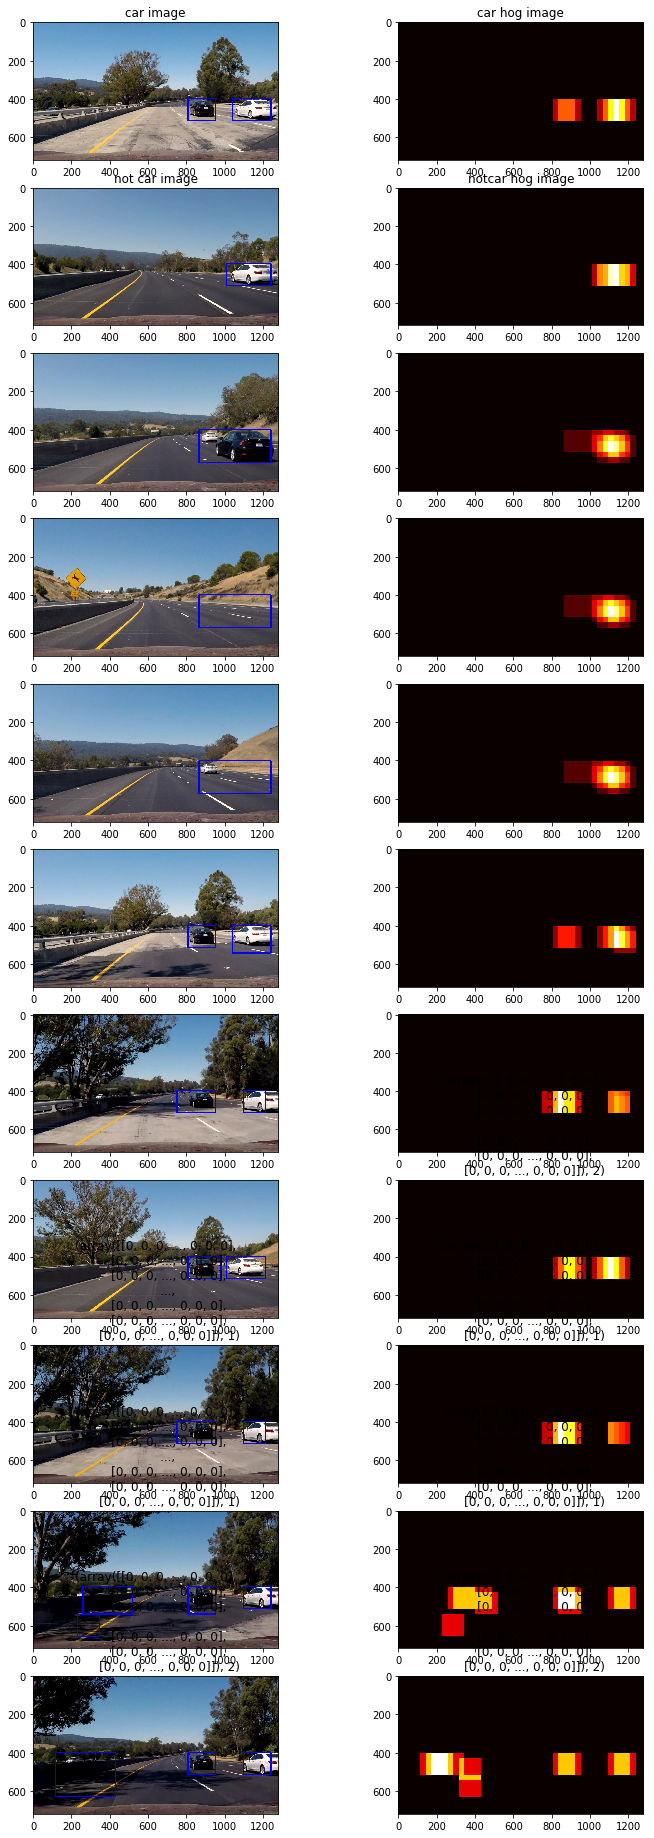

In [24]:
#Run test on Test Images to Decide which parameters (check cell #9 for parameters) Gets The Best Results
#Apply Threshold to reduce false-positives
out_images=[]
out_maps=[]

if True:
    for file in files:    
        img = mpimg.imread(file)       
        _,heatmap = find_cars(img, scales)   

        heatmap=apply_threshold(heatmap,threshold)
        labels = label(heatmap)     
        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        out_images.append(draw_img)    
        out_images.append(heatmap)    
        titles.append(labels)

    fig = plt.figure(figsize=(12,36))
    visualize(fig, 12 ,2, out_images, titles)

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def process_image(image):
    
    out_img, heatmap = find_cars(image,scales) 
    heatmap=apply_threshold(heatmap,threshold)
    labels=label(heatmap)    
    draw_img=draw_labeled_bboxes(np.copy(image),labels)
    return draw_img

In [19]:
output='./output_videos/video_9.mp4'
#heatmap=[]
clip=VideoFileClip('project_video.mp4').subclip(0,0)
warped_clip=clip.fl_image(process_image)
%time warped_clip.write_videofile(output,audio=False)   

[MoviePy] >>>> Building video ./output_videos/video_8.mp4
[MoviePy] Writing video ./output_videos/video_8.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:33<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/video_8.mp4 

Wall time: 7min 34s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))
